In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import nltk
import sklearn
import string

In [ ]:
df_path = '/content/drive/MyDrive/poems_dataset.csv'

In [ ]:
df = pd.read_csv(df_path, nrows = None)
df.dataframeName = 'poems_dataset.csv'
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')


There are 144123 rows and 6 columns


In [ ]:
df.head()

,Unnamed: 0,0,1,2,source,hash
0,0,fishing boats,colors of,the rainbow,tempslibres,FISHINGBOATSCOLORSOFTHERAINBOW
1,1,ash wednesday--,trying to remember,my dream,tempslibres,ASHWEDNESDAYTRYINGTOREMEMBERMYDREAM
2,2,snowy morn--,pouring another cup,of black coffee,tempslibres,SNOWYMORNPOURINGANOTHERCUPOFBLACKCOFFEE
3,3,shortest day,flames dance,in the oven,tempslibres,SHORTESTDAYFLAMESDANCEINTHEOVEN
4,4,haze,half the horse hidden,behind the house,tempslibres,HAZEHALFTHEHORSEHIDDENBEHINDTHEHOUSE


In [ ]:

# pre-process, drop the first column
df = df.drop(columns=df.columns[0]) # remove unnecessary column
df.drop(index=df.index[60000:],
        axis=0,
        inplace=True)
df.head(), df.shape

(                 0                      1                 2       source  \
 0    fishing boats              colors of       the rainbow  tempslibres   
 1  ash wednesday--    trying to remember           my dream  tempslibres   
 2     snowy morn--    pouring another cup   of black coffee  tempslibres   
 3     shortest day           flames dance       in the oven  tempslibres   
 4             haze  half the horse hidden  behind the house  tempslibres   
 
                                       hash  
 0           FISHINGBOATSCOLORSOFTHERAINBOW  
 1      ASHWEDNESDAYTRYINGTOREMEMBERMYDREAM  
 2  SNOWYMORNPOURINGANOTHERCUPOFBLACKCOFFEE  
 3          SHORTESTDAYFLAMESDANCEINTHEOVEN  
 4     HAZEHALFTHEHORSEHIDDENBEHINDTHEHOUSE  ,
 (60000, 5))

In [ ]:
df.describe

<bound method NDFrame.describe of                           0                             1  \
0             fishing boats                     colors of   
1           ash wednesday--           trying to remember    
2              snowy morn--           pouring another cup   
3              shortest day                  flames dance   
4                      haze         half the horse hidden   
...                     ...                           ...   
59995   I hate shopping for     presents with a passion I   
59996      I really enjoyed   myself this weekend with my   
59997      Have a Happy and    Safe Halloween from all of   
59998  Merry Christmas Rach    Sending all my love to you   
59999    And I'm going back   to school only for the hoes   

                         2       source  \
0              the rainbow  tempslibres   
1                 my dream  tempslibres   
2          of black coffee  tempslibres   
3              in the oven  tempslibres   
4         behind t

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       60000 non-null  object
 1   1       60000 non-null  object
 2   2       59999 non-null  object
 3   source  60000 non-null  object
 4   hash    59999 non-null  object
dtypes: object(5)
memory usage: 2.3+ MB


In [ ]:
df.describe

<bound method NDFrame.describe of                           0                             1  \
0             fishing boats                     colors of   
1           ash wednesday--           trying to remember    
2              snowy morn--           pouring another cup   
3              shortest day                  flames dance   
4                      haze         half the horse hidden   
...                     ...                           ...   
59995   I hate shopping for     presents with a passion I   
59996      I really enjoyed   myself this weekend with my   
59997      Have a Happy and    Safe Halloween from all of   
59998  Merry Christmas Rach    Sending all my love to you   
59999    And I'm going back   to school only for the hoes   

                         2       source  \
0              the rainbow  tempslibres   
1                 my dream  tempslibres   
2          of black coffee  tempslibres   
3              in the oven  tempslibres   
4         behind t

In [ ]:
from nltk.corpus import cmudict
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('cmudict')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


True

In [ ]:
cmu_dictionary =cmudict.dict()
words_not_found_in_cmu_dict = []
len(cmu_dictionary)

123455

In [ ]:
# Make haikus lowercase
for columns in df[['0','1','2']]:
    df[columns] = df[columns].str.lower()

In [ ]:
df.shape

(60000, 5)

In [ ]:
def count_syllables_in_word(word):
    # Attempt to find the number of syllables in a word
    # Source: https://datascience.stackexchange.com/questions/23376/how-to-get-the-number-of-syllables-in-a-word
    try:
        # Check the number of syllables in the word using a dictionary
        return [len(list(s for s in phonemes if s[-1].isdigit())) for phonemes in cmu_dictionary[word.lower()]][0]
    except:
        # If the word isn't found in the dictionary, mark it for future reference and return -1
        words_not_found_in_cmu_dict.append(word)
        return -1

def check_syllable_count(poem):
    # Check if a given poem has the correct syllable count per line
    for line_index, sentence in enumerate(poem):
        total_syllables = 0
        try:
            # Count syllables in each word of the sentence
            for word in sentence.split():
                syllables = count_syllables_in_word(word)
                if syllables != -1:
                    total_syllables += count_syllables_in_word(word)
                else:
                    return False  # If a word isn't found in the dictionary, return False
            # Check syllable count based on the line index
            if line_index == 0 or line_index == 2:
                if total_syllables != 5:
                    return False  # For the first and third lines, should have 5 syllables
            elif line_index == 1:
                if total_syllables != 7:
                    return False  # For the second line, should have 7 syllables
                    break
        except:
            return False  # Return False if any error occurs during processing
    return True  # Return True if the poem has the correct syllable count per line


In [ ]:
all_poems = df[['0','1','2']].to_numpy()
all_poems.shape

(60000, 3)

In [ ]:
# Remove poems that do not follow 5-7-5 syllable structure
df = df[[check_syllable_count(poem) for poem in all_poems]]
df.head(), df.shape

(                           0                             1  \
 24       visiting the graves     stronger the october wind   
 141  profound blue of night    the resin and salt of pines   
 142  scattered in the ditch   like tiny scraps of blue sky   
 343   the smell of her hands     on the neck of the bottle   
 435       christmas services    a cellular phone rings out   
 
                        2       source  \
 24   at my grandparents'  tempslibres   
 141  so far from the sea  tempslibres   
 142  bits of plastic bag  tempslibres   
 343    drinking greedily  tempslibres   
 435     handel's messiah  tempslibres   
 
                                                   hash  
 24   VISITINGTHEGRAVESSTRONGERTHEOCTOBERWINDATMYGRA...  
 141  PROFOUNDBLUEOFNIGHTTHERESINANDSALTOFPINESSOFAR...  
 142  SCATTEREDINTHEDITCHLIKETINYSCRAPSOFBLUESKYBITS...  
 343  THESMELLOFHERHANDSONTHENECKOFTHEBOTTLEDRINKING...  
 435  CHRISTMASSERVICESACELLULARPHONERINGSOUTHANDELS...  ,
 (26327, 5))

In [ ]:
df.columns

Index(['0', '1', '2', 'source', 'hash'], dtype='object')

In [ ]:
help(word_tokenize)

Help on function word_tokenize in module nltk.tokenize:

word_tokenize(text, language='english', preserve_line=False)
    Return a tokenized copy of *text*,
    using NLTK's recommended word tokenizer
    (currently an improved :class:`.TreebankWordTokenizer`
    along with :class:`.PunktSentenceTokenizer`
    for the specified language).
    
    :param text: text to split into words
    :type text: str
    :param language: the model name in the Punkt corpus
    :type language: str
    :param preserve_line: A flag to decide whether to sentence tokenize the text or not.
    :type preserve_line: bool



In [ ]:
# Function to create a string instance based on specific columns in a DataFrame
def combine_columns_to_string(index):
    # Ensuring the index is non-negative
    assert index >= 0, 'Index cannot be a negative integer'

    # Retrieving the row at the specified index
    selected_row = df.iloc[index, :]

    # Combining columns 0, 1, and 2 into a single string
    # making the poem seem together at similar manner
    combined_string = str(selected_row[0]) + str(selected_row[1]) + str(selected_row[2])

    return combined_string

# Applying the function to each row in the df
document = [combine_columns_to_string(i) for i in range(len(df.iloc[:, 2]))]
print(len(document))
document[:5]

26327


["visiting the gravesstronger the october windat my grandparents'",
 'profound blue of night the resin and salt of pinesso far from the sea',
 'scattered in the ditch like tiny scraps of blue skybits of plastic bag',
 'the smell of her handson the neck of the bottledrinking greedily',
 "christmas servicesa cellular phone rings outhandel's messiah"]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# vectorize the sentence
vectorizer = CountVectorizer(stop_words='english')


example_matrix = vectorizer.fit_transform([combine_columns_to_string(1)])
print(example_matrix)
feature_names = vectorizer.get_feature_names_out()
pd.DataFrame.sparse.from_spmatrix(example_matrix,
                                  columns=feature_names)

  (0, 4)	1
  (0, 0)	1
  (0, 2)	1
  (0, 5)	1
  (0, 6)	1
  (0, 3)	1
  (0, 1)	1
  (0, 7)	1


,blue,far,night,pinesso,profound,resin,salt,sea
0,1,1,1,1,1,1,1,1


In [ ]:
def preprocess_texts(one_line_poem):
    """Preprocess the one_line_poem."""

    # Break text into words
    #Ignoring numbers and symbols, so only lower case and upper case alphabets
    # the length of character has to be minimum of 3
    tokenizer = RegexpTokenizer(r'[A-Za-z]{3,}')

    # separation of one_line poem based on the tokenizer above
    words = tokenizer.tokenize(one_line_poem)


    # Tag words with Parts of Speech (POS) tags
    # J is for adjectives, N is for nouns, R is for adverbs, V is for verbs
    # required for identifying the grammatical properties of each word
    tag_mapping = {'J': 'a', 'N': 'n', 'R': 'r', 'V': 'v'}
    tagged_words = pos_tag(words)

    # Lowercase and lemmatize considering its POS tag and lowercasing it.
    # Using the tag_mapping to map POS tags obtained to those expected by the lemmatizer.
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word.lower(), pos=tag_mapping.get(tag[0], 'v')) for word, tag in tagged_words]

    # Remove stopwords
    cleaned_words = [word for word in lemmatized if word not in stop_words]

    return cleaned_words


In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
count_vectorizer = CountVectorizer(analyzer=preprocess_texts)
poem_matrix = count_vectorizer.fit_transform(document)
print(poem_matrix.shape)

(26327, 30074)


In [ ]:
feature_names = count_vectorizer.get_feature_names_out()
feature_names.shape

(30074,)

In [ ]:
# the count of appearance of words in the corresponding poems represented in each rows
pd.DataFrame.sparse.from_spmatrix(poem_matrix,
                                  columns=feature_names)

,aaa,aalbum,aalso,aam,aangry,aaron,aawful,ab,ababy,ababysitter,...,zipperi,zoe,zombie,zombies,zombiesscrewed,zone,zonebut,zoo,zooi,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26322,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26323,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26324,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26325,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline


In [ ]:
# Make list of topics names
topics_list = []
#assuming total number of topics be 15 as a whole
for n in range(15):
    topics_list.append('topic'+str(n+1))


In [ ]:
lda = LatentDirichletAllocation(n_components=15, random_state=0)
lda.fit(poem_matrix)

LatentDirichletAllocation(n_components=15, random_state=0)

LatentDirichletAllocation(n_components=15, random_state=0)

In [ ]:
pipe = Pipeline([('vectorizer', CountVectorizer(analyzer=preprocess_texts)),
                 ('lda', LatentDirichletAllocation(n_components=15, learning_method='online', random_state=0))])
pipe.fit(document)# Inspect topics
feature_names = pipe['vectorizer'].get_feature_names_out()
# describe_topics(pipe['lda'], feature_names, top_n_words=10)

In [ ]:
df[topics_list] = lda.transform(example_matrix)

df['best topic'] = df.iloc[:, 5:5+15].idxmax(axis=1)
df['best probability'] = df.iloc[:, 5:5+15].max(axis=1)

topic_list = df['best topic'].values
len(topic_list)

<ipython-input-60-75c2d3d05fbf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[topics_list] = lda.transform(example_matrix)
<ipython-input-60-75c2d3d05fbf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[topics_list] = lda.transform(example_matrix)
<ipython-input-60-75c2d3d05fbf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

26327

In [ ]:
#this gives topic for each poem in every row of the poems
#thus, the shape is seen as
topic_list.shape

(26327,)

In [ ]:
df.head()

,0,1,2,source,hash,topic1,topic2,topic3,topic4,topic5,...,topic8,topic9,topic10,topic11,topic12,topic13,topic14,topic15,best topic,best probability
24,visiting the graves,stronger the october wind,at my grandparents',tempslibres,VISITINGTHEGRAVESSTRONGERTHEOCTOBERWINDATMYGRA...,0.011111,0.011111,0.011111,0.011111,0.011111,...,0.011111,0.011111,0.011111,0.011111,0.844444,0.011111,0.011111,0.011111,topic12,0.844444
141,profound blue of night,the resin and salt of pines,so far from the sea,tempslibres,PROFOUNDBLUEOFNIGHTTHERESINANDSALTOFPINESSOFAR...,0.007407,0.896296,0.007407,0.007407,0.007407,...,0.007407,0.007407,0.007407,0.007407,0.007407,0.007407,0.007407,0.007407,topic2,0.896296
142,scattered in the ditch,like tiny scraps of blue sky,bits of plastic bag,tempslibres,SCATTEREDINTHEDITCHLIKETINYSCRAPSOFBLUESKYBITS...,0.006667,0.006667,0.006667,0.006667,0.006667,...,0.006667,0.906666,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,topic9,0.906666
343,the smell of her hands,on the neck of the bottle,drinking greedily,tempslibres,THESMELLOFHERHANDSONTHENECKOFTHEBOTTLEDRINKING...,0.011111,0.011111,0.011111,0.011111,0.011111,...,0.844444,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,topic8,0.844444
435,christmas services,a cellular phone rings out,handel's messiah,tempslibres,CHRISTMASSERVICESACELLULARPHONERINGSOUTHANDELS...,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.139525,0.008333,0.008333,0.512645,0.247830,topic14,0.512645


In [ ]:
df

,0,1,2,source,hash,topic1,topic2,topic3,topic4,topic5,...,topic8,topic9,topic10,topic11,topic12,topic13,topic14,topic15,best topic,best probability
24,visiting the graves,stronger the october wind,at my grandparents',tempslibres,VISITINGTHEGRAVESSTRONGERTHEOCTOBERWINDATMYGRA...,0.011111,0.011111,0.011111,0.011111,0.011111,...,0.011111,0.011111,0.011111,0.011111,0.844444,0.011111,0.011111,0.011111,topic12,0.844444
141,profound blue of night,the resin and salt of pines,so far from the sea,tempslibres,PROFOUNDBLUEOFNIGHTTHERESINANDSALTOFPINESSOFAR...,0.007407,0.896296,0.007407,0.007407,0.007407,...,0.007407,0.007407,0.007407,0.007407,0.007407,0.007407,0.007407,0.007407,topic2,0.896296
142,scattered in the ditch,like tiny scraps of blue sky,bits of plastic bag,tempslibres,SCATTEREDINTHEDITCHLIKETINYSCRAPSOFBLUESKYBITS...,0.006667,0.006667,0.006667,0.006667,0.006667,...,0.006667,0.906666,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,topic9,0.906666
343,the smell of her hands,on the neck of the bottle,drinking greedily,tempslibres,THESMELLOFHERHANDSONTHENECKOFTHEBOTTLEDRINKING...,0.011111,0.011111,0.011111,0.011111,0.011111,...,0.844444,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,topic8,0.844444
435,christmas services,a cellular phone rings out,handel's messiah,tempslibres,CHRISTMASSERVICESACELLULARPHONERINGSOUTHANDELS...,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.139525,0.008333,0.008333,0.512645,0.247830,topic14,0.512645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,i hate shopping for,presents with a passion i,can't say it enough,twaiku,IHATESHOPPINGFORPRESENTSWITHAPASSIONICANTSAYIT...,0.008333,0.008333,0.008333,0.883333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,topic4,0.883333
59996,i really enjoyed,myself this weekend with my,second family,twaiku,IREALLYENJOYEDMYSELFTHISWEEKENDWITHMYSECONDFAMILY,0.011111,0.335707,0.011111,0.011111,0.011111,...,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.519848,topic15,0.519848
59997,have a happy and,safe halloween from all of,us at mahaffey,twaiku,HAVEAHAPPYANDSAFEHALLOWEENFROMALLOFUSATMAHAFFEY,0.011111,0.011111,0.011111,0.011111,0.011111,...,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.844444,topic15,0.844444
59998,merry christmas rach,sending all my love to you,today and always,twaiku,MERRYCHRISTMASRACHSENDINGALLMYLOVETOYOUTODAYAN...,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.494587,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.397080,topic8,0.494587


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

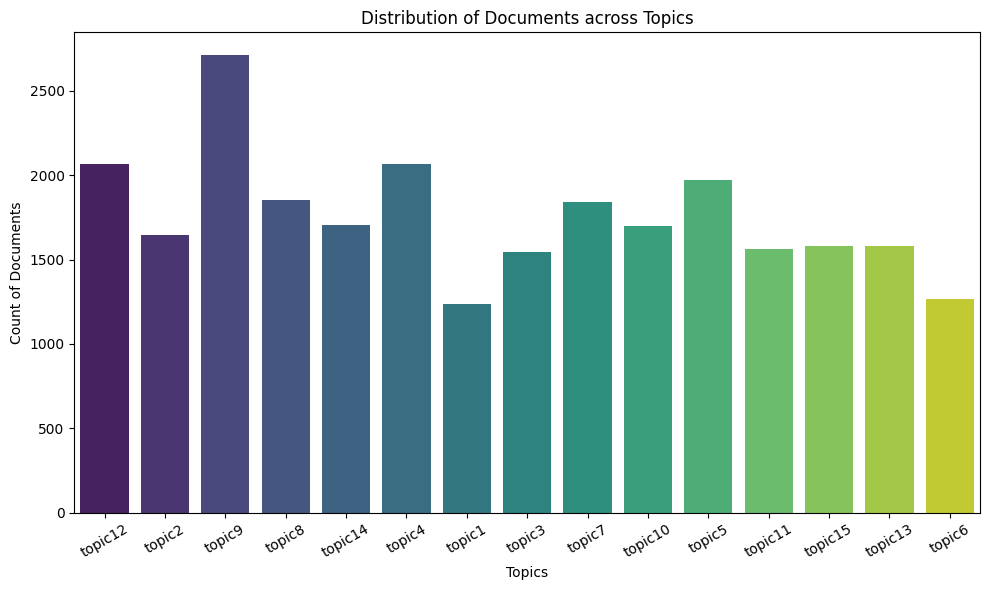

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='best topic', palette='viridis')
plt.xlabel('Topics')
plt.ylabel('Count of Documents')
plt.title('Distribution of Documents across Topics')
plt.xticks(rotation=30)
plt.tight_layout()
plt.grid = True
plt.show()

## Here we can see the topic9 is the most common topic for about 2500+ poems in the dataset

In [ ]:
# Preprocessing the text data
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
processed_text = []

for i in range(len(df)):
    processed_line = []
    for col in df.columns[:-2]:  # Exclude the 'Source' column
        # Tokenize, remove stopwords, and apply stemming to each word
        words = word_tokenize(df[col][i].lower())
        words = [ps.stem(word) for word in words if word.isalpha() and word not in stop_words]
        processed_line.extend(words)
    processed_text.append(processed_line)

# Visualizing word frequency
all_words = [word for line in processed_text for word in line]
freq_dist = FreqDist(all_words)
freq_dist.plot(20, cumulative=False)
plt.show()

KeyError: ignored